In [ ]:
# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install equinox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.4 MB/s eta 0:00:00


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import yaml
from tabulate import tabulate
import csv
import jax.numpy as jnp
import equinox as eqx
from jax.scipy.special import sph_harm
import numpy as np
import jax.numpy as jnp
from scipy.spatial import cKDTree
from typing import Dict
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import Path
import pandas as pd
import numpy as np
import os
import jax
import jax.numpy as jnp
import optax
from functools import partial
from typing import Sequence
import time
from tqdm.notebook import tqdm

In [ ]:
import os
# Define the target directory in Google Drive
target_dir = '/content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/'

# Create the target directory if it doesn't exist (within Google Drive)
os.makedirs(target_dir, exist_ok=True)

yaml_file_path = '/content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/configs/example.yaml'

try:
    with open(yaml_file_path, 'r') as f:
        config = yaml.safe_load(f)
        dataset_url = config.get('dataset_url')

        if dataset_url:
            # Download the zip file using the URL from the YAML
            !wget "{dataset_url}" -O "{target_dir}toluene.zip"

            # Unzip the file
            !unzip -o "{target_dir}toluene.zip" -d "{target_dir}"
        else:
            print("Error: 'dataset_url' not found in the YAML configuration.")

except FileNotFoundError:
    print(f"Error: YAML file '{yaml_file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

--2025-05-09 17:54:56--  http://quantum-machine.org/gdml/data/npz/toluene_ccsd_t.zip
Resolving quantum-machine.org (quantum-machine.org)... 130.149.80.145
Connecting to quantum-machine.org (quantum-machine.org)|130.149.80.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1045362 (1021K) [application/zip]
Saving to: ‘/content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/toluene.zip’

/content/drive/MyDr 100%[===================>]   1021K   686KB/s    in 1.5s    

2025-05-09 17:54:58 (686 KB/s) - ‘/content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/toluene.zip’ saved [1045362/1045362]

Archive:  /content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/toluene.zip
  inflating: /content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/toluene_ccsd_t-train.npz  
   creating: /content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/__MACOSX/
  inflating: /content/drive/MyDrive/Co

In [ ]:
# Flatten nested dictionaries
def flatten_dict(d, parent_key='', sep='.'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# Load and flatten the YAML config
with open(yaml_file_path, 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

flat_config = flatten_dict(config)

# Convert to tabular format
table_data = list(flat_config.items())
print(tabulate(table_data, headers=["Parameter", "Value"], tablefmt=None))

Parameter                                    Value
-------------------------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
root                                         results/toluene
run_name                                     example-run-toluene
seed                                         123
dataset_seed                                 456
append                                       True
default_dtype                                float64
model_dtype                                  float32
allow_tf32                                   True
r_max                                        4.0
num_layers                                   4
l_max                                        2
parity                                       True
num_features               

Load and Process the NPZ File Using Your Dataset Logic

In [ ]:
# Load the toluene NPZ
npz_path = Path("/content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/benchmark_data/toluene_ccsd_t-train.npz")
data_file = np.load(npz_path, allow_pickle=True)

print("Loaded .npz file with filename keys as:", list(data_file.keys()))

for key in data_file.keys():

  value = data_file[key]
  print(f"{key}: shape = {value.shape}, dtype = {value.dtype}")

records = []

# Detect number of frames
num_frames = 0
for key in ['E', 'F', 'R']:
    if key in data_file and data_file[key].ndim > 0:
        num_frames = data_file[key].shape[0]
        break
else:
    print("Warning: Could not determine number of frames.")

# Determine number of atoms from first frame
num_atoms = 0
if 'R' in data_file and data_file['R'].ndim == 3:
    num_atoms = data_file['R'].shape[1]
elif 'F' in data_file and data_file['F'].ndim == 3:
    num_atoms = data_file['F'].shape[1]
elif 'z' in data_file and data_file['z'].ndim == 1:
    num_atoms = data_file['z'].shape[0]
else:
    print("Warning: Could not determine number of atoms.")

# Property categorization
atom_property_keys = ['R', 'F']
atom_scalar_property_keys = ['z']
global_property_keys = [key for key in data_file.keys() if key not in atom_property_keys + atom_scalar_property_keys]

# Build records
for frame_idx in range(num_frames):
    # Global frame-level metadata (like energy, name, theory, etc.)
    frame_data = {}
    for key in global_property_keys:
        value = data_file[key]
        if isinstance(value, np.ndarray) and value.ndim > 0 and value.shape[0] > frame_idx:
            frame_data[key] = value[frame_idx]
        else:
            frame_data[key] = value

    # Atom-wise data for this frame
    pos = data_file.get('R')
    forces = data_file.get('F')
    z = data_file.get('z')  # atomic numbers

    for atom_idx in range(num_atoms):
        record = {
            "frame": frame_idx,
            "atom_index": atom_idx,
        }
        record.update(frame_data)  # Global fields into atom row

        if pos is not None and pos.ndim == 3:
            record["x"] = pos[frame_idx, atom_idx, 0]
            record["y"] = pos[frame_idx, atom_idx, 1]
            record["z"] = pos[frame_idx, atom_idx, 2]

        if forces is not None and forces.ndim == 3:
            record["fx"] = forces[frame_idx, atom_idx, 0]
            record["fy"] = forces[frame_idx, atom_idx, 1]
            record["fz"] = forces[frame_idx, atom_idx, 2]

        if z is not None and z.ndim == 1:
            record["atomic_number"] = int(z[atom_idx])

        records.append(record)

# Create DataFrame
df = pd.DataFrame.from_records(records)

Loaded .npz file with filename keys as: ['E', 'name', 'F', 'theory', 'R', 'z', 'type', 'md5']
E: shape = (1000, 1), dtype = float64
name: shape = (), dtype = |S12
F: shape = (1000, 15, 3), dtype = float64
theory: shape = (), dtype = |S1
R: shape = (1000, 15, 3), dtype = float64
z: shape = (15,), dtype = uint8
type: shape = (), dtype = |S1
md5: shape = (), dtype = |S32


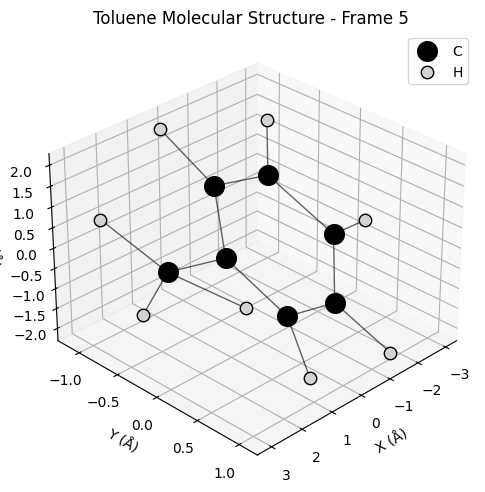

In [ ]:
# Visualize 3D structure of the molecule at a specific frame
def plot_molecular_structure(df, frame_idx=0):
    # Filter data for the specific frame
    frame_data = df[df['frame'] == frame_idx]

    # Create an atomic number to element name and color mapping
    element_map = {1: 'H', 6: 'C', 7: 'N', 8: 'O'}
    color_map = {1: 'lightgray', 6: 'black', 7: 'blue', 8: 'red'}
    size_map = {1: 80, 6: 200, 7: 200, 8: 200}

    # Create 3D plot
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection='3d')

    # Plot atoms
    for _, atom in frame_data.iterrows():
        atomic_num = atom['atomic_number']
        element = element_map.get(atomic_num, 'X')
        color = color_map.get(atomic_num, 'gray')
        size = size_map.get(atomic_num, 100)

        ax.scatter(
            atom['x'], atom['y'], atom['z'],
            color=color, s=size, edgecolors='black',
            label=f"{element}" if element not in [l.get_label() for l in ax.get_lines()] else ""
        )

    # Draw bonds (simplified approach - connect atoms that are close)
    positions = frame_data[['x', 'y', 'z']].values
    for i in range(len(positions)):
        for j in range(i+1, len(positions)):
            # Calculate distance between atoms
            dist = np.sqrt(np.sum((positions[i] - positions[j])**2))
            # If atoms are close enough, draw a bond
            if dist < 1.7:  # Typical bond length threshold in Angstroms
                ax.plot(
                    [positions[i, 0], positions[j, 0]],
                    [positions[i, 1], positions[j, 1]],
                    [positions[i, 2], positions[j, 2]],
                    'k-', linewidth=1, alpha=0.6
                )

    # Remove duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='best')

    # Set labels and title
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.set_title(f'Toluene Molecular Structure - Frame {frame_idx}')

    # Adjust view angle for better visualization
    ax.view_init(elev=30, azim=45)
    plt.tight_layout()
    plt.show()


# Plot molecular structure at frame 5
plot_molecular_structure(df, frame_idx=5)

In [ ]:
class NequIPDatasetJAX:
    def __init__(self, npz_path: str, r_max: float, max_neighbors: int = 32):
        """
        Args:
            npz_path: Path to .npz file with keys 'R', 'F', 'E', 'z'.
            r_max: cutoff radius for neighbor search.
            max_neighbors: maximum number of neighbors per atom.
        """
        data = np.load(npz_path, allow_pickle=True)
        self.R = data['R']  # (n_frames, n_atoms, 3)
        self.F = data['F']  # (n_frames, n_atoms, 3)
        self.E = data['E']  # (n_frames,)
        self.Z = data['z']  # (n_atoms,)

        self.n_frames, self.n_atoms, _ = self.R.shape
        self.r_max = r_max
        self.max_neighbors = max_neighbors

        # Precompute neighbor lists
        self.neighbor_idx = np.zeros((self.n_frames, self.n_atoms, max_neighbors), dtype=np.int32)
        self.neighbor_mask = np.zeros((self.n_frames, self.n_atoms, max_neighbors), dtype=bool)
        self.neighbor_dist = np.zeros((self.n_frames, self.n_atoms, max_neighbors), dtype=np.float32)
        for t in range(self.n_frames):
            pos = self.R[t]
            tree = cKDTree(pos)
            all_nbrs = tree.query_ball_tree(tree, self.r_max)
            for i, nbrs in enumerate(all_nbrs):
                # remove self
                nbrs = [j for j in nbrs if j != i]
                # sort by distance
                dists = np.linalg.norm(pos[nbrs] - pos[i], axis=1)
                sorted_idx = np.argsort(dists)
                nbrs = [nbrs[k] for k in sorted_idx][:max_neighbors]
                # fill arrays
                k = len(nbrs)
                self.neighbor_idx[t, i, :k] = nbrs
                self.neighbor_mask[t, i, :k] = True
                self.neighbor_dist[t, i, :k] = dists[sorted_idx[:k]]

    def __len__(self) -> int:
        return self.n_frames

    def get(self, idx: int) -> Dict[str, jnp.ndarray]:
        """
        Get single graph as JAX arrays.
        """
        pos    = jnp.array(self.R[idx])            # (n_atoms,3)
        forces = jnp.array(self.F[idx])            # (n_atoms,3)
        energy = jnp.array(self.E[idx])            # ()
        z      = jnp.array(self.Z)                 # (n_atoms,)
        nbr_idx = jnp.array(self.neighbor_idx[idx])# (n_atoms,max_neighbors)
        nbr_dist= jnp.array(self.neighbor_dist[idx])# (n_atoms,max_neighbors)
        mask    = jnp.array(self.neighbor_mask[idx])# (n_atoms,max_neighbors)
        return {
            'pos': pos,
            'z': z,
            'nbr_idx': nbr_idx,
            'nbr_dist': nbr_dist,
            'nbr_mask': mask,
            'energy': energy,
            'forces': forces
        }

    def get_batch(self, indices: np.ndarray) -> Dict[str, jnp.ndarray]:
        """
        Batch multiple graphs (assuming same number of nodes per graph).
        """
        batch = {k: jnp.stack([self.get(i)[k] for i in indices]) for k in self.get(indices[0])}
        return batch

In [ ]:
# Parse cutoff and neighbor count from flat_config
r_max_value = flat_config['r_max']
r_max = float(r_max_value)

avg_nbr = flat_config.get('avg_num_neighbors', 'auto')
if isinstance(avg_nbr, (int, float)):
    max_neighbors = int(avg_nbr)
elif isinstance(avg_nbr, str) and avg_nbr.lower() == 'auto':
    max_neighbors = 32
else:
    max_neighbors = int(avg_nbr)

print("Using r_max =", r_max, "and max_neighbors =", max_neighbors)

Using r_max = 4.0 and max_neighbors = 32


In [ ]:
# Now initialize and test
ds = NequIPDatasetJAX(
    npz_path,
    r_max=r_max,
    max_neighbors=max_neighbors
)
sample = ds.get(0)
print({k: v.shape for k, v in sample.items()})


{'pos': (15, 3), 'z': (15,), 'nbr_idx': (15, 32), 'nbr_dist': (15, 32), 'nbr_mask': (15, 32), 'energy': (1,), 'forces': (15, 3)}


In [ ]:
class RealSphericalHarmonics(eqx.Module):
    """
    Manual real spherical harmonics for l_max up to 2.
    Produces components in the order:
      l=0:  Y₀⁰
      l=1:  Y₁⁻¹, Y₁⁰, Y₁¹
      l=2:  Y₂⁻², Y₂⁻¹, Y₂⁰, Y₂¹, Y₂²
    """
    l_max: int
    num_harmonics: int

    def __init__(self, l_max: int):
        assert 0 <= l_max <= 2, "Supports l_max ∈ {0,1,2, 3}"
        # compute how many components: 1 + 3 (if l>=1) + 5 (if l>=2)
        num = 1 + (3 if l_max >= 1 else 0) + (5 if l_max >= 2 else 0)
        self.l_max = l_max
        self.num_harmonics = num
        super().__init__()

    def __call__(self, vecs: jnp.ndarray) -> jnp.ndarray:
        x, y, z = vecs[..., 0], vecs[..., 1], vecs[..., 2]
        r2 = x*x + y*y + z*z + 1e-16
        r = jnp.sqrt(r2)

        out = []
        # ℓ=0
        out.append(
            jax.lax.cond(
                self.l_max >= 0,
                lambda _: 0.5 * jnp.sqrt(1 / jnp.pi) * jnp.ones_like(r),
                lambda _: jnp.zeros_like(r),
                operand=None,  # No specific operand needed here
            )
        )
        # ℓ=1
        # Ensure consistent output structure using jnp.zeros_like for false_fun
        out.extend(
            jax.lax.cond(
                self.l_max >= 1,
                lambda _: [
                    jnp.sqrt(3 / (4 * jnp.pi)) * (y / r),
                    jnp.sqrt(3 / (4 * jnp.pi)) * (z / r),
                    jnp.sqrt(3 / (4 * jnp.pi)) * (x / r),
                ],
                lambda _: [jnp.zeros_like(r), jnp.zeros_like(r), jnp.zeros_like(r)],
                operand=None,
            )
        )
        # ℓ=2
        # Ensure consistent output structure using jnp.zeros_like for false_fun
        out.extend(
            jax.lax.cond(
                self.l_max >= 2,
                lambda _: [
                    jnp.sqrt(15 / (4 * jnp.pi)) * (x * y) / r2,
                    jnp.sqrt(15 / (4 * jnp.pi)) * (y * z) / r2,
                    0.25 * jnp.sqrt(5 / jnp.pi) * (2 * z * z - x * x - y * y) / r2,
                    jnp.sqrt(15 / (4 * jnp.pi)) * (x * z) / r2,
                    0.5 * jnp.sqrt(15 / jnp.pi) * (x * x - y * y) / r2,
                ],
                lambda _: [
                    jnp.zeros_like(r),
                    jnp.zeros_like(r),
                    jnp.zeros_like(r),
                    jnp.zeros_like(r),
                    jnp.zeros_like(r),
                ],
                operand=None,
            )
        )
        return jnp.stack(out, axis=-1)

In [ ]:
class GaussianSmearing(eqx.Module):
    """
    Expands scalar distances into Gaussian radial basis functions.
    """
    centers: jnp.ndarray
    widths:  jnp.ndarray

    def __init__(self, start: float, stop: float, num_basis: int):
        # compute centers and widths
        centers = jnp.linspace(start, stop, num_basis)
        widths  = jnp.full((num_basis,), (stop - start) / (num_basis - 1))
        # assign as plain attributes
        self.centers = centers
        self.widths  = widths
        # register with Equinox
        super().__init__()

    def __call__(self, distances: jnp.ndarray) -> jnp.ndarray:
        d = jnp.expand_dims(distances, axis=-1)      # (...,1)
        diff = d - self.centers                      # (..., num_basis)
        return jnp.exp(-0.5 * (diff / self.widths) ** 2)


In [ ]:
class EquivariantConv(eqx.Module):
    """
    Equivariant message-passing convolution block.
    """
    radial_fn: eqx.Module    # GaussianSmearing
    sph_fn:    eqx.Module    # RealSphericalHarmonics
    W:         jnp.ndarray   # weights of shape (B, H, in_feats, out_feats)

    def __init__(
        self,
        rbf: eqx.Module,
        sph: eqx.Module,
        in_feats: int,
        out_feats: int,
        key: jax.random.PRNGKey = None
    ):
        # store sub-modules
        self.radial_fn = rbf
        self.sph_fn    = sph
        # initialize weight tensor
        B = rbf.centers.shape[0]
        H = sph.num_harmonics
        rng = jax.random.PRNGKey(0) if key is None else key
        scale = 1.0 / jnp.sqrt(in_feats * B * H)
        self.W = jax.random.normal(rng, (B, H, in_feats, out_feats)) * scale
        # register fields
        super().__init__()

    def __call__(
        self,
        feats:     jnp.ndarray,   # (n_atoms, in_feats)
        pos:       jnp.ndarray,   # (n_atoms, 3)
        nbr_idx:   jnp.ndarray,   # (n_atoms, n_nbr)
        nbr_dist:  jnp.ndarray,   # (n_atoms, n_nbr)
        nbr_mask:  jnp.ndarray    # (n_atoms, n_nbr) boolean
    ) -> jnp.ndarray:
        # gather neighbor positions
        nbr_pos   = pos[nbr_idx]               # (n_atoms, n_nbr, 3)
        vecs      = nbr_pos - pos[:, None, :]  # (n_atoms, n_nbr, 3)
        # compute radial and angular features
        phi       = self.radial_fn(nbr_dist)   # (n_atoms, n_nbr, B)
        Y         = self.sph_fn(vecs)          # (n_atoms, n_nbr, H)
        # neighbor features and mask
        nbr_feats = feats[nbr_idx]             # (n_atoms, n_nbr, in_feats)
        mask      = nbr_mask[..., None]        # (n_atoms, n_nbr, 1)

        # zero out invalid neighbors
        phi       *= mask
        Y         *= mask
        nbr_feats *= mask

        # message: sum over b,h,i  phi * Y * W * h_j
        msgs = jnp.einsum('anb,anh,bhio,ani->ano', phi, Y, self.W, nbr_feats)
        # aggregate
        return jnp.sum(msgs, axis=1)           # (n_atoms, out_feats)


In [ ]:
class NequIPModel(eqx.Module):
    embedding: jnp.ndarray
    convs:     Sequence
    w1:        jnp.ndarray
    b1:        jnp.ndarray
    w2:        jnp.ndarray
    b2:        jnp.ndarray

    def __init__(self, max_z, hidden_feats, r_max, num_basis, l_max, num_layers, key):
        keys = jax.random.split(key, 3 + num_layers)
        self.embedding = (jax.random.normal(keys[0], (max_z+1, hidden_feats))
                          * jnp.sqrt(1.0/hidden_feats))
        # shared RBF/SH
        rbf = GaussianSmearing(0.0, r_max, num_basis)
        sh  = RealSphericalHarmonics(l_max=l_max)
        # conv stack
        convs = [EquivariantConv(rbf, sh,
                                 hidden_feats, hidden_feats,
                                 key=keys[1+i])
                 for i in range(num_layers)]
        self.convs = tuple(convs)
        # manual readout
        k1, k2, _ = keys[-3], keys[-2], keys[-1]
        scale = jnp.sqrt(1.0/hidden_feats)
        self.w1 = jax.random.normal(k1, (hidden_feats, hidden_feats)) * scale
        self.b1 = jnp.zeros((hidden_feats,))
        self.w2 = jax.random.normal(k2, (hidden_feats, 1)) * scale
        self.b2 = jnp.array([mean_E_pa])
        super().__init__()

    def __call__(self, pos, z, nbr_idx, nbr_dist, nbr_mask):
        h = self.embedding[z]
        for conv in self.convs:
            h = jax.nn.silu(conv(h, pos, nbr_idx, nbr_dist, nbr_mask))
        h_read = jax.nn.silu(jnp.matmul(h, self.w1) + self.b1)
        e_i    = (jnp.matmul(h_read, self.w2) + self.b2).squeeze(-1)
        return jnp.sum(e_i)

    def forces(self, pos, z, nbr_idx, nbr_dist, nbr_mask):
        energy_fn = lambda p: self(p, z, nbr_idx, nbr_dist, nbr_mask)
        return -jax.grad(energy_fn)(pos)


In [ ]:
# Number of atoms per frame
n_atoms = ds.R.shape[1]

# Gather per‑atom energies for every frame
E_pa = []
for i in range(len(ds)):
    info = ds.get(i)
    E_pa.append(np.array(info['energy']) / n_atoms)
E_pa = np.stack(E_pa)          # shape (n_frames,)

mean_E_pa = float(E_pa.mean())
std_E_pa  = float(E_pa.std())
print(f"Dataset per‑atom energy: mean = {mean_E_pa:.4f}, std = {std_E_pa:.4f}")

Dataset per‑atom energy: mean = -11319.5703, std = 0.3731


In [ ]:
# re‐compute hyperparameters if needed
max_z     = int(jnp.max(ds.Z))
hidden    = int(flat_config['num_features'])
r_max     = float(flat_config['r_max'])
num_basis = int(flat_config['num_basis'])
l_max     = int(flat_config['l_max'])
n_layers  = int(flat_config['num_layers'])
seed      = int(flat_config['seed'])
key       = jax.random.PRNGKey(seed)

model = NequIPModel(max_z, hidden, r_max, num_basis, l_max, n_layers, key)
model

NequIPModel(
  embedding=f32[7,32],
  convs=(
    EquivariantConv(
      radial_fn=GaussianSmearing(centers=f32[8], widths=weak_f32[8]),
      sph_fn=RealSphericalHarmonics(l_max=2, num_harmonics=9),
      W=f32[8,9,32,32]
    ),
    EquivariantConv(
      radial_fn=GaussianSmearing(centers=f32[8], widths=weak_f32[8]),
      sph_fn=RealSphericalHarmonics(l_max=2, num_harmonics=9),
      W=f32[8,9,32,32]
    ),
    EquivariantConv(
      radial_fn=GaussianSmearing(centers=f32[8], widths=weak_f32[8]),
      sph_fn=RealSphericalHarmonics(l_max=2, num_harmonics=9),
      W=f32[8,9,32,32]
    ),
    EquivariantConv(
      radial_fn=GaussianSmearing(centers=f32[8], widths=weak_f32[8]),
      sph_fn=RealSphericalHarmonics(l_max=2, num_harmonics=9),
      W=f32[8,9,32,32]
    )
  ),
  w1=f32[32,32],
  b1=f32[32],
  w2=f32[32,1],
  b2=f32[1]
)

In [ ]:
class EquivariantConv(eqx.Module):
    """
    Equivariant message-passing convolution block.
    """
    radial_fn: eqx.Module      # GaussianSmearing
    sph_fn:    eqx.Module      # RealSphericalHarmonics
    W:         jnp.ndarray     # weights of shape (B, H, in_feats, out_feats)

    def __init__(
        self,
        rbf: eqx.Module,
        sph: eqx.Module,
        in_feats: int,
        out_feats: int,
        key=None
    ):
        # assign submodules
        self.radial_fn = rbf
        self.sph_fn    = sph
        # weight init
        B = rbf.centers.shape[0]
        H = sph.num_harmonics
        rng = jax.random.PRNGKey(0) if key is None else key
        scale = 1.0 / jnp.sqrt(in_feats * B * H)
        self.W = jax.random.normal(rng, (B, H, in_feats, out_feats)) * scale
        super().__init__()

    def __call__(
        self,
        feats: jnp.ndarray,       # (n_atoms, in_feats)
        pos:   jnp.ndarray,       # (n_atoms, 3)
        nbr_idx:  jnp.ndarray,    # (n_atoms, n_nbr)
        nbr_dist: jnp.ndarray,    # (n_atoms, n_nbr)
        nbr_mask: jnp.ndarray     # (n_atoms, n_nbr) boolean
    ) -> jnp.ndarray:
        # gather neighbor data
        nbr_pos   = pos[nbr_idx]               # (n_atoms, n_nbr, 3)
        vecs      = nbr_pos - pos[:, None, :]  # (n_atoms, n_nbr, 3)
        phi       = self.radial_fn(nbr_dist)   # (n_atoms, n_nbr, B)
        Y         = self.sph_fn(vecs)          # (n_atoms, n_nbr, H)
        nbr_feats = feats[nbr_idx]             # (n_atoms, nbr, in_feats)
        mask      = nbr_mask[..., None]        # (n_atoms, n_nbr, 1)

        # apply mask
        phi       = phi       * mask
        Y         = Y         * mask
        nbr_feats = nbr_feats * mask

        # compute messages: sum over b,h,i  phi * Y * W * h_j
        msgs = jnp.einsum('anb,anh,bhio,ani->ano', phi, Y, self.W, nbr_feats)
        return jnp.sum(msgs, axis=1)           # (n_atoms, out_feats)


In [ ]:
# --- Build train/validation split ---
n_val     = int(flat_config['n_val'])
idx_all   = jnp.arange(len(ds))
train_idx = idx_all[:-n_val]
val_idx   = idx_all[-n_val:]

# --- Precomputed normalization constants (from earlier) ---
# mean_E_pa, std_E_pa, std_F

# Gather all force components across your dataset
F_all = []
for i in range(len(ds)):
    frame = ds.get(i)
    F_all.append(np.array(frame['forces']))   # shape (n_atoms, 3)
F_all = np.stack(F_all)                       # shape (n_frames, n_atoms, 3)
std_F = float(F_all.std())                    # a single scalar
# print("Global force std:", std_F)

# … your train/val split and std_F computation above …
checkpoint_root: str = "/content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/train/trained_example_models"

In [ ]:
def run_training(
    model,
    dataset,
    train_idx,
    val_idx,
    *,
    learning_rate: float = float(flat_config['learning_rate']),
    force_coeff:   float = float(flat_config['loss_coeffs.forces']),
    batch_size:    int   = int(flat_config['batch_size']),
    num_epochs:    int   = int(flat_config['max_epochs']),
    patience:      int   = int(flat_config['early_stopping_patiences.validation_loss']),
    min_delta:     float = float(flat_config['early_stopping_lower_bounds.LR']),
    print_every:   int   = 1,
    seed:          int   = int(flat_config['seed']),
):
    key = jax.random.PRNGKey(seed)
    os.makedirs(checkpoint_root, exist_ok=True)
    print("In training …")

    # Learning‐rate schedule & optimizer
    steps_per_epoch = max(1, train_idx.shape[0] // batch_size)
    total_steps     = steps_per_epoch * num_epochs
    lr_schedule = optax.cosine_decay_schedule(
        init_value=learning_rate,
        decay_steps=total_steps,
        alpha=0.0,  # decay all the way to zero
    )
    optimizer = optax.adamw(
        learning_rate=lr_schedule,
        weight_decay=1e-5,
    )
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    # Metrics containers
    train_e_losses = []
    train_f_losses = []
    val_e_losses   = []
    val_f_losses   = []
    lrs            = []
    step = 0  # will count *batches*

    # Loss fn
    def compute_loss(model, batch):
        # energy
        def single_energy(pos, z, nbr_idx, nbr_dist, nbr_mask):
            return model(pos, z, nbr_idx, nbr_dist, nbr_mask)
        E_pred = jax.vmap(single_energy)(
            batch['pos'], batch['z'],
            batch['nbr_idx'], batch['nbr_dist'], batch['nbr_mask']
        )
        # forces
        def single_force(pos, z, nbr_idx, nbr_dist, nbr_mask):
            return model.forces(pos, z, nbr_idx, nbr_dist, nbr_mask)
        F_pred = jax.vmap(single_force)(
            batch['pos'], batch['z'],
            batch['nbr_idx'], batch['nbr_dist'], batch['nbr_mask']
        )
        # per-atom‐energy MSE (standardized)
        n_atoms    = batch['pos'].shape[1]
        E_pa_pred  = (E_pred / n_atoms - mean_E_pa) / std_E_pa
        E_pa_true  = (batch['energy'] / n_atoms - mean_E_pa) / std_E_pa
        e_loss     = jnp.mean((E_pa_pred - E_pa_true)**2)
        # force MSE (standardized)
        F_s_pred   = F_pred / std_F
        F_s_true   = batch['forces'] / std_F
        f_loss     = jnp.mean((F_s_pred - F_s_true)**2)
        return e_loss + force_coeff * f_loss, (e_loss, f_loss)

    # Single‐step (jit‑compiled)
    @jax.jit
    def train_step(model, opt_state, batch, force_coeff):
        (loss, (e_loss, f_loss)), grads = eqx.filter_value_and_grad(
            compute_loss, has_aux=True
        )(model, batch)
        params = eqx.filter(model, eqx.is_array)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss, e_loss, f_loss

    # Early‑stop setup
    # os.makedirs("checkpoint_root", exist_ok=True)
    best_val = float("inf")
    wait     = 0

    # Training loop
    start_all = time.time()
    for epoch in tqdm(range(1, num_epochs + 1), desc="Epochs"):
        t0 = time.time()

        # record current LR
        lrs.append(float(lr_schedule(step)))

        # **inner loop over batches**
        perm = jax.random.permutation(key, train_idx.shape[0])
        for i in range(0, train_idx.shape[0], batch_size):
            batch_idx = train_idx[perm[i : i + batch_size]]
            batch     = dataset.get_batch(batch_idx)
            model, opt_state, loss, e_loss, f_loss = train_step(
                model, opt_state, batch, force_coeff
            )
            # ← **BUMP** the step counter *per batch* so the LR schedule advances
            step += 1

        # Log train metrics
        train_e_losses.append(float(e_loss))
        train_f_losses.append(float(f_loss))

        # Evaluate on validation set
        _, (val_e, val_f) = compute_loss(model, dataset.get_batch(val_idx))
        val_loss = float(val_e + force_coeff * val_f)
        val_e_losses.append(float(val_e))
        val_f_losses.append(float(val_f))

        # Timing & logging
        t1 = time.time()
        if epoch % print_every == 0:
            elapsed = t1 - start_all
            print(
                f"Epoch {epoch}/{num_epochs}  "
                f"time this epoch: {t1-t0:.1f}s  "
                f"elapsed: {elapsed/60:.1f}m  "
                f"train E={e_loss:.4f}, F={f_loss:.4f}  "
                f"val E={val_e:.4f}, F={val_f:.4f}"
            )

        # Early stopping & checkpoint
        if best_val - val_loss > min_delta:
            best_val = val_loss
            wait     = 0
            ckpt = f"{checkpoint_root}/best_epoch{epoch}.eqx"
            eqx.tree_serialise_leaves(ckpt, model)
            print(f" ↳ New best val_loss={best_val:.4f}, saved to {ckpt}")
        else:
            wait += 1
            if wait >= patience:
                print(f"Stopping early after {epoch} epochs (no improvement).")
                break

    # Return everything
    metrics = {
        "train_e": train_e_losses,
        "train_f": train_f_losses,
        "val_e":   val_e_losses,
        "val_f":   val_f_losses,
        "lr":      lrs,
    }
    return model, opt_state, metrics

Tune Hyperparameters. Override yaml config as per model needs

In [ ]:
learning_rate = float(flat_config['learning_rate'])
force_coeff   = float(flat_config['loss_coeffs.forces'])
batch_size    = int(flat_config['batch_size'])
num_epochs    = int(flat_config['max_epochs'])
seed          = int(flat_config['seed'])
key           = jax.random.PRNGKey(seed)

## HARDCODE Hypoerparameters
# batch_size = 8
num_epochs = 200
learning_rate = 0.001
print(f"learning_rate {learning_rate}")
print(f"force_coeff {force_coeff}")
print(f"batch_size {batch_size}")
print(f"num_epochs {num_epochs}")
print(f"seed {seed}")

learning_rate 0.001
force_coeff 1.0
batch_size 5
num_epochs 200
seed 123


In [ ]:
# Run training
print_every = 1

model, opt_state, metrics = run_training(
    model,
    ds,
    train_idx,
    val_idx,
    num_epochs=num_epochs,
    patience = 200,
    print_every= print_every,
    learning_rate=learning_rate,
    force_coeff= 1.0,
)

# After training, serialize the final model
eqx.tree_serialise_leaves(f"{checkpoint_root}/final_model.eqx", model)
print(f"Saved final model to {checkpoint_root}/final_model.eqx")

In training …


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200  time this epoch: 133.5s  elapsed: 2.2m  train E=0.8312, F=0.7946  val E=1.0559, F=0.9301
 ↳ New best val_loss=1.9860, saved to /content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/train/trained_example_models/best_epoch1.eqx
Epoch 2/200  time this epoch: 75.8s  elapsed: 3.5m  train E=0.8425, F=0.7947  val E=1.0577, F=0.9301
Epoch 3/200  time this epoch: 79.2s  elapsed: 4.8m  train E=0.8392, F=0.7947  val E=1.0576, F=0.9301
Epoch 4/200  time this epoch: 75.0s  elapsed: 6.1m  train E=0.8392, F=0.7947  val E=1.0576, F=0.9301
Epoch 5/200  time this epoch: 77.8s  elapsed: 7.4m  train E=0.8392, F=0.7947  val E=1.0576, F=0.9301
Epoch 6/200  time this epoch: 75.5s  elapsed: 8.6m  train E=0.8392, F=0.7947  val E=1.0575, F=0.9301
Epoch 7/200  time this epoch: 75.0s  elapsed: 9.9m  train E=0.8384, F=0.7947  val E=1.0572, F=0.9301
Epoch 8/200  time this epoch: 78.7s  elapsed: 11.2m  train E=0.8352, F=0.7947  val E=1.0567, F=0.9301
Epoch 9/200  time this epoch: 79.7s  elapsed: 12.

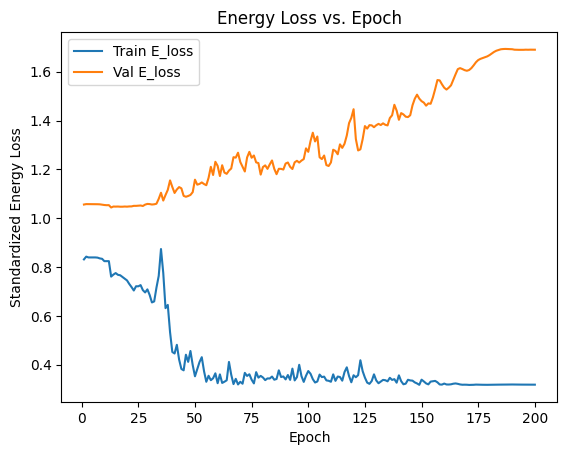

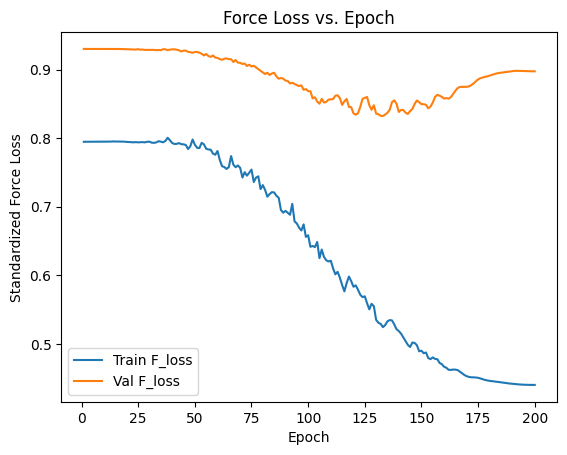

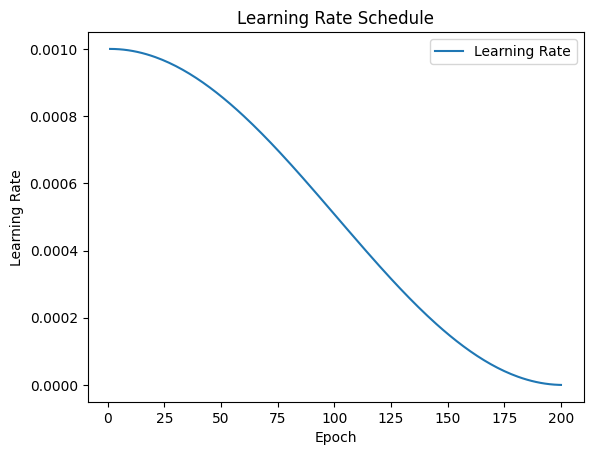

In [ ]:
# Ensure `metrics` is in scope (returned by your updated run_training)
epochs = list(range(1, len(metrics['train_e']) + 1))

# 1) Energy Loss Plot
plt.figure()
plt.plot(epochs, metrics['train_e'], label='Train E_loss')
plt.plot(epochs, metrics['val_e'],   label='Val E_loss')
plt.xlabel('Epoch')
plt.ylabel('Standardized Energy Loss')
plt.title('Energy Loss vs. Epoch')
plt.legend()
plt.show()

# 2) Force Loss Plot
plt.figure()
plt.plot(epochs, metrics['train_f'], label='Train F_loss')
plt.plot(epochs, metrics['val_f'],   label='Val F_loss')
plt.xlabel('Epoch')
plt.ylabel('Standardized Force Loss')
plt.title('Force Loss vs. Epoch')
plt.legend()
plt.show()

# 3) Learning Rate Schedule
plt.figure()
plt.plot(epochs, metrics['lr'], label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

In [ ]:
n_epochs = len(metrics['train_e'])
df = pd.DataFrame({
    'epoch':                      list(range(1, n_epochs+1)),
    'train/loss/energy_mae':      metrics['train_e'],
    'train/loss/forces_mse':      metrics['train_f'],
    'val/loss/energy_mae':        metrics['val_e'],
    'val/loss/forces_mse':        metrics['val_f'],
    'train/metric/learning_rate': metrics['lr'],
     'val/metric/learning_rate':  metrics['lr'],
})

# point here instead of flat_config paths
outdir = "/content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/train/example_train/results"
os.makedirs(outdir, exist_ok=True)

metrics_csv = os.path.join(outdir, "metrics_example.csv")
df.to_csv(metrics_csv, index=False)
print(f"Wrote metrics to {metrics_csv}")

Wrote metrics to /content/drive/MyDrive/Colab_Notebooks/Nequip_reimplement/train/example_train/results/metrics_example.csv


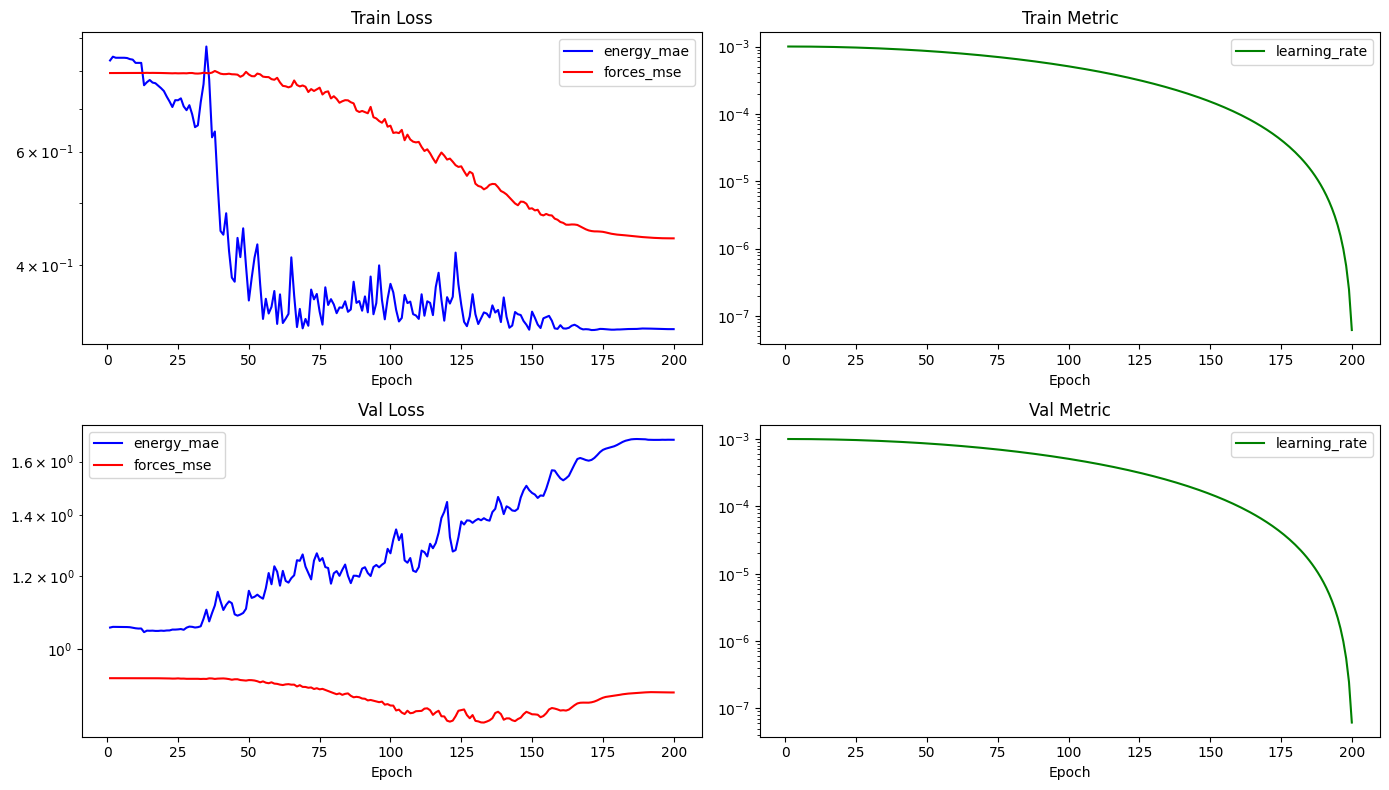

In [ ]:
plt.rcParams.update({'font.size': 10})

# Define colors_dict here
colors_dict = {
    'energy_mae': 'blue',
    'forces_mse': 'red',
    'learning_rate': 'green',
    # Add more mappings as needed
}

def get_metrics(df, group="train", type="loss"):
    if group == "train":
        cols = [c for c in df.columns if all(x in c for x in ["train", type])]
    else:
        cols = [c for c in df.columns if all(x in c for x in [group, type])]
    keep = ["epoch"] + cols
    sub = df[keep].dropna(subset=cols)
    renamed = {c: c.split("/")[-1] for c in cols}
    return sub.rename(columns=renamed), list(renamed.values())

def plot_metric_in_ax(ax, df, group="train", type="loss"):
    df_sub, names = get_metrics(df, group, type)
    lines, labels = [], []
    for name in names:
        color = colors_dict.get(name, None)
        line, = ax.plot(df_sub["epoch"], df_sub[name], color=color)
        lines.append(line)
        labels.append(name)
    ax.set_yscale("log")
    ax.set_xlabel("Epoch")
    ax.set_title(f"{group.title()} {type.title()}")
    ax.legend(lines, labels)

def plot_metrics(df):
    fig, axes = plt.subplots(2, 2, figsize=(14,8))
    plot_metric_in_ax(axes[0,0], df, "train", "loss")
    plot_metric_in_ax(axes[0,1], df, "train", "metric")
    plot_metric_in_ax(axes[1,0], df, "val",   "loss")
    plot_metric_in_ax(axes[1,1], df, "val",   "metric")
    plt.tight_layout()
    plt.show()

# load and plot
metrics_df = pd.read_csv(metrics_csv)
plot_metrics(metrics_df)

In [1]:
!pip freeze > requirements.txt

In [2]:
!pip install nbformat

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached referencing-0.36.2-py3-none-any.whl.metadata (2.8 kB)
  Using cached rpds_py-0.24.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached fastjsonschema-2.21.1-py3-none-any.whl (23 kB)
Using cached jsonschema-4.23.0-py3-none-any.whl (88 kB)
Using cached attrs-25.3.0-py3-none-any.whl (63 kB)
Using cached referencing-0.36.2-py3-none-any.whl (26 kB)
Using cached rpds_py-0.24.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (393 kB)


In [5]:

# === Replace with your file path ===
notebook_path = "Nequip_example_dataset_100frames.ipynb"

import nbformat
from pathlib import Path

# Load the notebook
with open(notebook_path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=nbformat.NO_CONVERT)

# Remove 'widgets' from metadata if it exists
if "widgets" in nb.metadata:
    print("🧹 Removing 'metadata.widgets'...")
    del nb.metadata["widgets"]

# Save the notebook back (overwrites original)
with open(notebook_path, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print(f"✅ Cleaned and saved: {notebook_path}")



🧹 Removing 'metadata.widgets'...
✅ Cleaned and saved: Nequip_example_dataset_100frames.ipynb
